In [ ]:
!pip install --upgrade pymorphy2
!pip install --upgrade pymorphy2-dicts
!pip install --upgrade gensim
!pip install --upgrade pyLDAvis

Requirement already up-to-date: pymorphy2 in /usr/local/lib/python3.7/dist-packages (0.9.1)
Requirement already up-to-date: pymorphy2-dicts in /usr/local/lib/python3.7/dist-packages (2.4.393442.3710985)
Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)
Requirement already up-to-date: pyLDAvis in /usr/local/lib/python3.7/dist-packages (3.2.2)


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np


import string
import re
from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('russian') #this depends on each language

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving data.xlsx to data (2).xlsx


In [ ]:
data = pd.read_excel('data.xlsx', sheet_name = 0)
text = data['Отзыв '].values

In [ ]:
data.shape[0]

1699

In [ ]:
data.head(1)

,Платформа,Название курса,Отзыв,Оценка,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Coursera,Введение в машинное обучение,"Я получила, хорошее представление о том, что в...",5,NaN,NaN,187.0


In [ ]:
text = data['Отзыв '].values.tolist()

In [ ]:
pprint(text[:1])

['Я получила, хорошее представление о том, что вообще такое машинное обучение, '
 'и некую начальную теор базу. Почти под любую тему есть ссылка на '
 'соответствующие полноценные написанные лекции, которые очень помогали '
 'получить более широкую картину. И самое главное были интересные и полезные '
 'практические задания.']


In [ ]:
print(stopWords)
my_stopWords = {'который', 'какой','нельзя','всегда','больше','имхо','николай','мой','это','некоторый','другой','также','этот','кроме','таким образом','тот','хотя','например','анатолий','то есть','такой'}
del_words = { 'лучше','хорошо', 'много', 'более', 'больше', 'великий_великий'}
all_stopWords = stopWords.union(my_stopWords)
all_stopWords.difference_update(del_words)
print(all_stopWords)

{'какая', 'эти', 'бы', 'ведь', 'ничего', 'хорошо', 'наконец', 'с', 'было', 'при', 'какой', 'тоже', 'потому', 'вдруг', 'ее', 'была', 'все', 'три', 'им', 'ним', 'два', 'когда', 'тем', 'ж', 'всех', 'из', 'на', 'или', 'перед', 'тебя', 'разве', 'того', 'над', 'здесь', 'мой', 'в', 'через', 'может', 'этого', 'уж', 'всю', 'ли', 'этой', 'чуть', 'даже', 'будто', 'тогда', 'что', 'ну', 'теперь', 'конечно', 'под', 'нее', 'эту', 'хоть', 'их', 'себя', 'чем', 'такой', 'будет', 'много', 'потом', 'там', 'уже', 'без', 'себе', 'после', 'сам', 'опять', 'только', 'кто', 'же', 'а', 'о', 'были', 'он', 'ты', 'вас', 'чтоб', 'никогда', 'них', 'за', 'как', 'ни', 'да', 'по', 'где', 'ему', 'вот', 'от', 'другой', 'тот', 'нет', 'быть', 'еще', 'сейчас', 'ней', 'у', 'том', 'мне', 'этот', 'один', 'и', 'моя', 'иногда', 'лучше', 'об', 'к', 'мы', 'свою', 'то', 'всего', 'есть', 'почти', 'нас', 'раз', 'про', 'вы', 'для', 'впрочем', 'если', 'чего', 'зачем', 'всегда', 'надо', 'тут', 'не', 'я', 'но', 'этом', 'более', 'куда', 'ч

In [ ]:
def preprocess_text(text):
    text = str (text) .lower ()
    text = text.lower().replace("ё", "е")
    text = re.sub('[^а-яА-Я ]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.split()

text_token = [preprocess_text(t) for t in text]   
print(text_token[0])

['я', 'получила', 'хорошее', 'представление', 'о', 'том', 'что', 'вообще', 'такое', 'машинное', 'обучение', 'и', 'некую', 'начальную', 'теор', 'базу', 'почти', 'под', 'любую', 'тему', 'есть', 'ссылка', 'на', 'соответствующие', 'полноценные', 'написанные', 'лекции', 'которые', 'очень', 'помогали', 'получить', 'более', 'широкую', 'картину', 'и', 'самое', 'главное', 'были', 'интересные', 'и', 'полезные', 'практические', 'задания']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
!pip install pymorphy2

In [ ]:
import spacy
import time
import pymorphy2
#make blank model with russian language 
def lemmatization(text):
    result = []
    lemmas = []
    start_time = time.time()
    for t in text:
        for word in t:
            lemmas.append(morph.parse(word)[0].normal_form)
        result.append(lemmas)
        lemmas = []
    print("Lemmatization time: ", time.time() - start_time, " seconds")
    return result

morph = pymorphy2.MorphAnalyzer()
text_lem = lemmatization(text_token)                 
print(text_lem[0])

Lemmatization time:  12.679912805557251  seconds
['я', 'получить', 'хороший', 'представление', 'о', 'тот', 'что', 'вообще', 'такой', 'машинный', 'обучение', 'и', 'некий', 'начальный', 'теор', 'база', 'почти', 'под', 'любой', 'тема', 'есть', 'ссылка', 'на', 'соответствующий', 'полноценный', 'написать', 'лекция', 'который', 'очень', 'помогать', 'получить', 'более', 'широкий', 'картина', 'и', 'самый', 'главное', 'быть', 'интересный', 'и', 'полезный', 'практический', 'задание']


In [ ]:
def make_bigrams(texts):
    bigram = gensim.models.Phrases(all_stopWords, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

text_bigrams = make_bigrams(text_lem)
print(text_bigrams)

[['я', 'получить', 'хороший', 'представление', 'о', 'тот', 'что', 'вообще', 'такой', 'машинный', 'обучение', 'и', 'некий', 'начальный', 'теор', 'база', 'почти', 'под', 'любой', 'тема', 'есть', 'ссылка', 'на', 'соответствующий', 'полноценный', 'написать', 'лекция', 'который', 'очень', 'помогать', 'получить', 'более', 'широкий', 'картина', 'и', 'самый', 'главное', 'быть', 'интересный', 'и', 'полезный', 'практический', 'задание'], ['этот', 'курс', 'подойти', 'человек', 'с', 'различный', 'начальный', 'подготовка', 'если', 'у', 'вы', 'не', 'хватать', 'математический', 'подготовка', 'то', 'лекция', 'с', 'формула', 'быть', 'вы', 'напрягать', 'попробовать', 'не', 'обращать', 'на', 'формула', 'внимание', 'а', 'сосредоточиться', 'на', 'идея', 'осознать', 'идея', 'вы', 'помочь', 'воображение', 'если', 'не', 'помочь', 'то', 'хороший', 'новость', 'заключаться', 'в', 'тот', 'что', 'для', 'выполнение', 'задание', 'этот', 'формула', 'вы', 'не', 'понадобиться', 'задача', 'решаться', 'с', 'помощь', 'биб

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(text_bigrams)

# Create Corpus
texts = text_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('база', 1),
  ('более', 1),
  ('вообще', 1),
  ('главное', 1),
  ('задание', 1),
  ('интересный', 1),
  ('картина', 1),
  ('лекция', 1),
  ('любой', 1),
  ('машинный', 1),
  ('написать', 1),
  ('начальный', 1),
  ('некий', 1),
  ('обучение', 1),
  ('очень', 1),
  ('полезный', 1),
  ('полноценный', 1),
  ('получить', 2),
  ('помогать', 1),
  ('практический', 1),
  ('представление', 1),
  ('самый', 1),
  ('соответствующий', 1),
  ('ссылка', 1),
  ('тема', 1),
  ('теор', 1),
  ('хороший', 1),
  ('широкий', 1)],
 [('задание', 3),
  ('интересный', 1),
  ('лекция', 3),
  ('машинный', 1),
  ('начальный', 1),
  ('обучение', 1),
  ('очень', 1),
  ('хороший', 1),
  ('автор', 2),
  ('аз', 1),
  ('алгоритм', 1),
  ('библиотека', 1),
  ('большой', 1),
  ('введение', 1),
  ('весь', 1),
  ('внимание', 1),
  ('возразить', 1),
  ('воображение', 1),
  ('вполне', 1),
  ('время', 2),
  ('вызов', 1),
  ('выполнение', 1),
  ('выполнить', 1),
  ('дело', 1),
  ('дополнительный', 1),
  ('дружить', 1),
  ('з

In [ ]:
!pip install lda2vec

In [ ]:
lda2vec_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=50,
                                           update_every=1,
                                           chunksize=100,
                                           passes=4,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda2vec_model.print_topics())
doc_lda = lda2vec_model[corpus]

[(0,
  '0.037*"понятие" + 0.014*"надеяться" + 0.013*"звезда" + 0.011*"легко" + '
  '0.010*"профессор" + 0.010*"чёткий" + 0.009*"приложение" + 0.009*"просить" + '
  '0.009*"подход" + 0.008*"специальность"'),
 (1,
  '0.021*"качество" + 0.021*"объясняться" + 0.015*"ответ" + 0.012*"должный" + '
  '0.012*"низкий" + 0.010*"викторина" + 0.010*"ясный" + 0.009*"подробно" + '
  '0.009*"представить" + 0.008*"видео"'),
 (2,
  '0.088*"курс" + 0.033*"очень" + 0.029*"задание" + 0.016*"много" + '
  '0.016*"хороший" + 0.015*"большой" + 0.015*"время" + '
  '0.011*"программирование" + 0.009*"всё" + 0.009*"тема"'),
 (3,
  '0.025*"неделя" + 0.020*"слишком" + 0.018*"пример" + 0.015*"должный" + '
  '0.014*"курс" + 0.013*"объяснение" + 0.012*"мочь" + 0.011*"более" + '
  '0.010*"задача" + 0.010*"плохо"'),
 (4,
  '0.041*"курс" + 0.029*"обучение" + 0.023*"машинный" + 0.022*"хороший" + '
  '0.017*"математика" + 0.015*"плохой" + 0.013*"мочь" + 0.012*"студент" + '
  '0.012*"проблема" + 0.010*"алгебра"')]


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda2vec_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda2vec = CoherenceModel(model=lda2vec_model, texts=text_nostops, dictionary=id2word, coherence='c_v')
coherence_lda2vec = coherence_model_lda2vec.get_coherence()
print('\nCoherence Score: ', coherence_lda2vec)


Perplexity:  -7.4442407639707175

Coherence Score:  0.4480412238236885


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-08 11:02:17--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  5.95MB/s    in 2.6s    

2021-03-08 11:02:21 (5.95 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
    

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=text_nostops, start=3, limit=40, step=1)

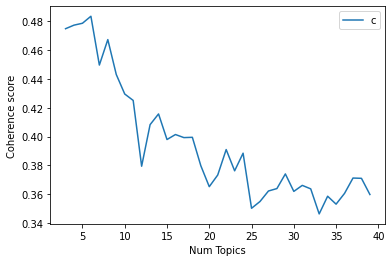

In [ ]:
# Show graph
limit=40; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4748
Num Topics = 4  has Coherence Value of 0.4773
Num Topics = 5  has Coherence Value of 0.4786
Num Topics = 6  has Coherence Value of 0.4835
Num Topics = 7  has Coherence Value of 0.4496
Num Topics = 8  has Coherence Value of 0.4673
Num Topics = 9  has Coherence Value of 0.443
Num Topics = 10  has Coherence Value of 0.4295
Num Topics = 11  has Coherence Value of 0.4251
Num Topics = 12  has Coherence Value of 0.3794
Num Topics = 13  has Coherence Value of 0.4082
Num Topics = 14  has Coherence Value of 0.4157
Num Topics = 15  has Coherence Value of 0.3979
Num Topics = 16  has Coherence Value of 0.4014
Num Topics = 17  has Coherence Value of 0.3993
Num Topics = 18  has Coherence Value of 0.3995
Num Topics = 19  has Coherence Value of 0.3798
Num Topics = 20  has Coherence Value of 0.3652
Num Topics = 21  has Coherence Value of 0.3733
Num Topics = 22  has Coherence Value of 0.391
Num Topics = 23  has Coherence Value of 0.3762
Num Topics = 24  has C